## Basic code to generate paper figures

In [1]:
%matplotlib widget
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
plt.style.use("./actroot.mplstyle")
import numpy as np
import cmcrameri.cm as cmc

In [2]:
# Define function to add colorbar axes
def add_colorbar(im, ax):
    cax = inset_axes(ax, width="5%", height="100%", loc="lower left",
                     bbox_to_anchor= (1.04, 0, 1, 1), bbox_transform = ax.transAxes, 
                     borderpad = 0)
    return plt.gcf().colorbar(im, cax = cax)

# Function to force X and Y ticks to be equal
def set_ticks(ax):
    ticks = np.arange(0, 128, 20)
    ax.set(xticks=ticks, yticks=ticks)
    return

# Main fcn to plot
def plot(matrix, filename, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4))

    im = ax.imshow(matrix.T, origin="lower", aspect="equal", interpolation="none", 
                   cmap=cmc.managua_r)
    set_ticks(ax)
    ax.set_xlabel("X [pads]", loc="right")
    ax.set_ylabel("Y [pads]", loc="top")
    # cbar = add_colorbar(im, ax)
    # cbar.ax.locator_params(nbins=5)
    if len(filename):
        plt.savefig(f"{filename}.pdf")

# Function to parse txt file
def parse(file: str, proj: str = "xy") -> np.ndarray:
    raw = np.loadtxt(file)
    if "3d" in proj:
        ret = np.zeros((128, 128, 128))
    else:
        ret = np.zeros((128, 128))
    dim = len(ret.shape)
    for x, y, z, q in raw:
        if dim == 3: 
            ret[int(x), int(y), int(z)] += q
        else:
            if "xy" in proj:
                ret[int(x), int(y)] += q
            else:
                ret[int(x), int(z)] += q
    ## Maske empty positions to Nan
    ret[ret == 0] = np.nan
    return ret

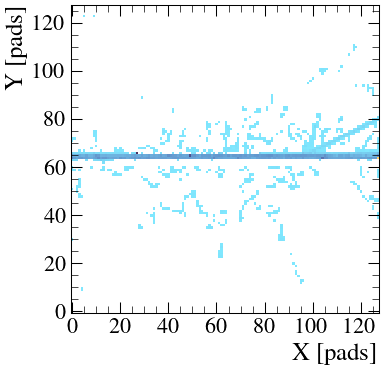

In [3]:
delta = parse("../Events/run_160_entry_49121.dat")
plot(delta, "delta_event")

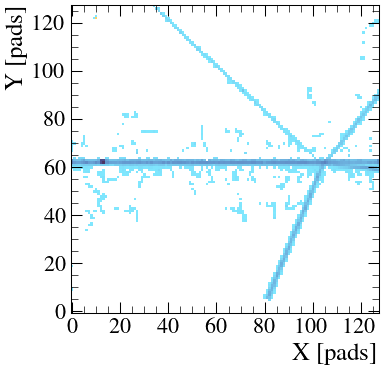

In [4]:
multi = parse("../Events/run_155_entry_38.dat")
plot(multi, "multi_event")

In [5]:
threed = parse("../Events/run_155_entry_1296.dat", "3d")
threexy = parse("../Events/run_155_entry_1296.dat")
threexz = parse("../Events/run_155_entry_1296.dat", "xz")
mask = ~np.isnan(threed)
x, y, z = np.where(mask)
q = threed[x, y, z]

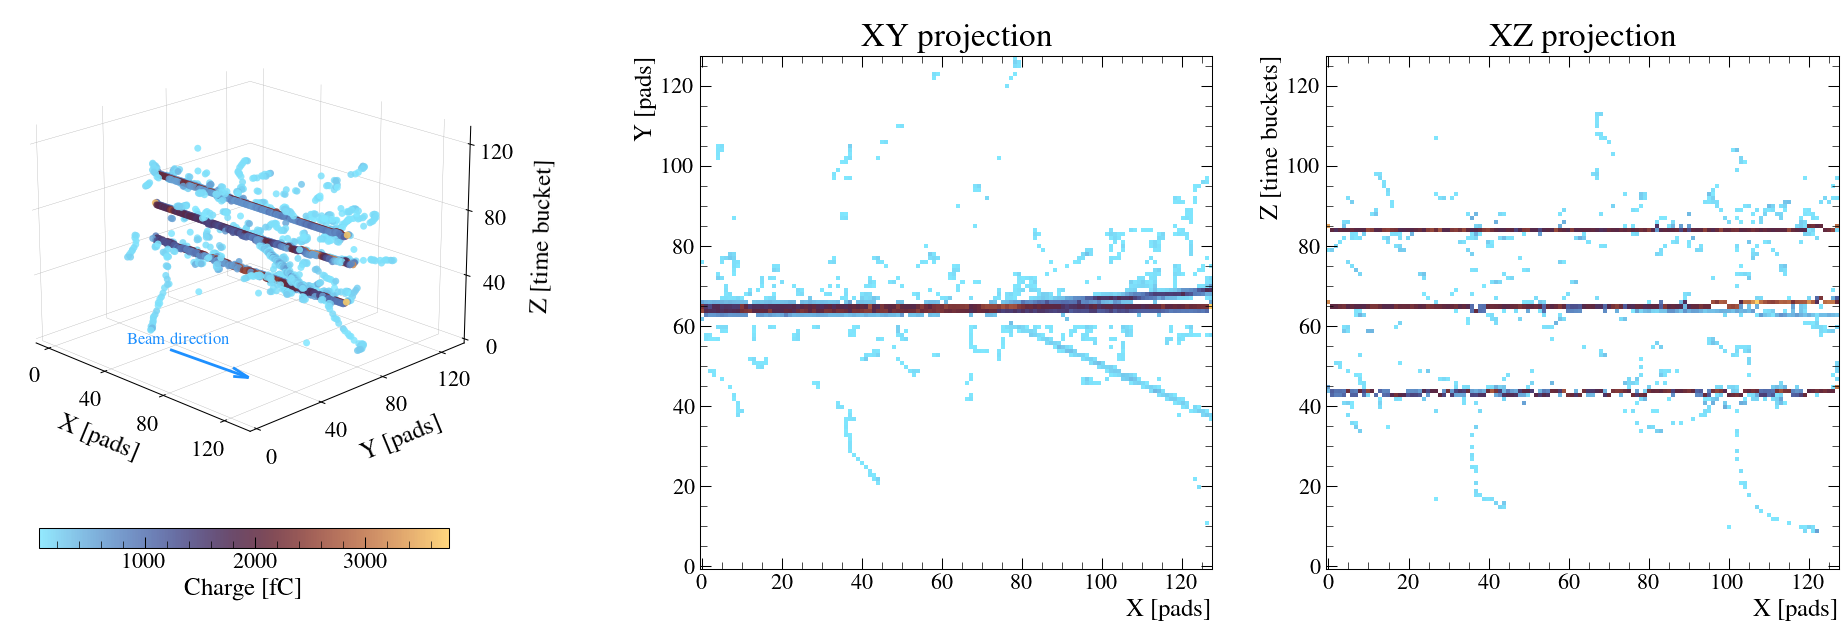

In [6]:
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams["grid.linewidth"] = 0.25

fig = plt.figure(figsize=(25,8))
gs = fig.add_gridspec(1, 3, width_ratios=[0.4, 0.3, 0.3])

ax = fig.add_subplot(gs[0], projection="3d")
sc = ax.scatter(x, y, z, c=q, cmap=cmc.managua_r, marker="o", s=25, edgecolor="none", linewidth=0.3, alpha=0.85)
# Colobar
cbar = fig.colorbar(sc, ax=ax, orientation="horizontal", pad=0.075, shrink=0.6)
cbar.set_label("Charge [fC]")
# cbar.ax.set_position([0.2, 1.05, 0.6, 0.3])

pad = 10
ax.set_xlabel("X [pads]", labelpad=pad)
ax.set_ylabel("Y [pads]", labelpad=pad)
ax.set_zlabel("Z [time bucket]", labelpad=pad)
labels = np.arange(0, 128, 40)
ax.set(xticks=labels, yticks=labels, zticks=labels)
ax.set_zlim(0, 128)

#Grid
ax.minorticks_off()
ax.zaxis.set_minor_locator(plt.NullLocator())

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# add_bounding_box(ax)
ax.view_init(elev=20, azim=-45)

## Annotation
ax.quiver(75, 5, 20, 50, 1, 1, color='dodgerblue', linewidth=2, arrow_length_ratio=0.2)  # Draw the arrow
ax.text(75, 10, 24, 'Beam direction', color='dodgerblue', fontsize=12, ha='center', va="center")  # Add text under the arrow


## 2d projections
ax2 = fig.add_subplot(gs[1])
plot(threexy, "", ax=ax2)
plt.gca().set_title("XY projection", fontsize=24)
ax3 = fig.add_subplot(gs[2])
plot(threexz, "", ax=ax3)
plt.gca().set_title("XZ projection", fontsize=24)
plt.gca().set_ylabel("Z [time buckets]", loc="top")

fig.savefig("3d_plot.pdf")